# Feature selection

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
%matplotlib inline

### load datasets

In [2]:
%store -r train_data_formodel
data = train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques

## configurations
* random_seed_state -> 
random_seed_state -> number, sets random state for model and for stratified splits 

In [3]:
random_seed_state = 42

# RFE, this isnt working yet, rankings all came out as 1

In [4]:
data.head()

,Analysis,Geology,Province,Region,Site,SubSite,Formation,Band,Nodule,Li7,Be9,B11,Mg24,Al27,Si28,P31,S33,K39,Ca42,Sc45,Ti47,V51,Cr52,Mn55,Fe56,Co59,Ni60,Cu63,Zn68,Ga69,Ge72,As75,Rb85,Sr88,Y89,Zr90,Nb93,Mo95,Cd111,In115,Sn118,Cs133,Ba137,La139,Ce140,Pr141,Nd146,Sm147,Eu153,Gd157,Tb159,Dy163,Ho165,Er166,Tm169,Yb172,Lu175,Hf178,Ta181,Pb208,Th232,U238,class
0,10_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,15.63,0.12,48.36,33.658126,943.71,464944.180000,50.280000,538.57,455.94,712.39,0.42,15.58,0.27,3.30,0.69,8.46,0.05,0.80,1.62,10.82,0.25,1.22,0.16,0.43,12.94,0.88,1.51,0.09,0.05,0.02,0.00,0.05,0.01,6.54,0.84,0.95,0.23,0.87,0.16,0.04,0.16,0.02,0.11,0.03,0.06,0.01,0.02,0.00,0.04,0.01,0.24,0.07,0.05,0
1,11_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,11.50,0.09,44.77,33.658126,1077.11,465010.940000,70.910000,438.20,387.82,515.24,0.44,18.47,0.29,3.45,1.01,11.59,0.11,0.36,0.53,8.93,0.34,0.85,0.10,0.45,13.22,0.95,1.74,0.07,0.01,0.02,0.00,0.04,0.02,8.04,0.92,1.01,0.23,0.98,0.18,0.04,0.18,0.02,0.13,0.03,0.06,0.01,0.04,0.01,0.05,0.00,0.07,0.08,0.04,0
2,12_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,20.05,0.06,44.88,42.700000,620.21,465295.410000,104.470000,372.66,363.71,957.89,0.76,19.89,0.55,3.25,1.21,87.99,0.21,1.68,1.53,11.98,0.25,1.71,0.13,0.43,8.52,0.87,0.93,0.10,0.02,0.02,0.00,0.05,0.01,3.13,0.90,1.08,0.26,0.84,0.15,0.04,0.19,0.02,0.14,0.02,0.07,0.01,0.06,0.00,0.02,0.01,0.46,0.05,0.05,0
3,13_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,11.16,0.73,47.06,33.658126,1143.19,462214.304116,2386.415832,1075.89,547.55,2174.30,0.43,42.30,0.67,152.42,4.84,145.34,0.30,2.45,5.02,17.15,0.35,2.13,0.84,0.76,13.16,0.97,2.00,0.10,0.29,0.18,0.01,0.78,0.04,8.74,0.93,0.95,0.21,0.75,0.13,0.04,0.25,0.02,0.09,0.03,0.05,0.00,0.03,0.00,0.08,0.00,0.64,0.05,0.03,0
4,14_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,17.71,0.32,48.26,33.520000,547.22,465027.110000,44.440000,464.78,278.25,1551.63,0.71,11.18,0.27,2.56,1.73,25.38,0.05,0.80,0.55,9.80,0.41,1.41,0.12,0.28,9.90,0.90,0.90,0.08,0.04,0.10,0.00,0.09,0.01,2.74,0.97,1.09,0.27,1.00,0.17,0.04,0.19,0.02,0.15,0.03,0.05,0.01,0.05,0.01,0.02,0.01,0.59,0.06,0.09,0


### Recursive feature elimination with cross-validation is done using a random forest as the estimator 

In [5]:
my_rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state = random_seed_state)



In [6]:
my_rfc_selector = RFECV(estimator=my_rfc, step=1, cv=StratifiedKFold(3), verbose=2, scoring='f1_macro')

In [7]:
data.columns.values[9:-1]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232', 'U238'], dtype=object)

data = pd.concat([data, tsne_dims_train, pca_dims_train[['PC1', 'PC2', 'PC3']]], axis = 1)

In [8]:
data.head()

,Analysis,Geology,Province,Region,Site,SubSite,Formation,Band,Nodule,Li7,Be9,B11,Mg24,Al27,Si28,P31,S33,K39,Ca42,Sc45,Ti47,V51,Cr52,Mn55,Fe56,Co59,Ni60,Cu63,Zn68,Ga69,Ge72,As75,Rb85,Sr88,Y89,Zr90,Nb93,Mo95,Cd111,In115,Sn118,Cs133,Ba137,La139,Ce140,Pr141,Nd146,Sm147,Eu153,Gd157,Tb159,Dy163,Ho165,Er166,Tm169,Yb172,Lu175,Hf178,Ta181,Pb208,Th232,U238,class
0,10_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,15.63,0.12,48.36,33.658126,943.71,464944.180000,50.280000,538.57,455.94,712.39,0.42,15.58,0.27,3.30,0.69,8.46,0.05,0.80,1.62,10.82,0.25,1.22,0.16,0.43,12.94,0.88,1.51,0.09,0.05,0.02,0.00,0.05,0.01,6.54,0.84,0.95,0.23,0.87,0.16,0.04,0.16,0.02,0.11,0.03,0.06,0.01,0.02,0.00,0.04,0.01,0.24,0.07,0.05,0
1,11_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,11.50,0.09,44.77,33.658126,1077.11,465010.940000,70.910000,438.20,387.82,515.24,0.44,18.47,0.29,3.45,1.01,11.59,0.11,0.36,0.53,8.93,0.34,0.85,0.10,0.45,13.22,0.95,1.74,0.07,0.01,0.02,0.00,0.04,0.02,8.04,0.92,1.01,0.23,0.98,0.18,0.04,0.18,0.02,0.13,0.03,0.06,0.01,0.04,0.01,0.05,0.00,0.07,0.08,0.04,0
2,12_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,20.05,0.06,44.88,42.700000,620.21,465295.410000,104.470000,372.66,363.71,957.89,0.76,19.89,0.55,3.25,1.21,87.99,0.21,1.68,1.53,11.98,0.25,1.71,0.13,0.43,8.52,0.87,0.93,0.10,0.02,0.02,0.00,0.05,0.01,3.13,0.90,1.08,0.26,0.84,0.15,0.04,0.19,0.02,0.14,0.02,0.07,0.01,0.06,0.00,0.02,0.01,0.46,0.05,0.05,0
3,13_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,11.16,0.73,47.06,33.658126,1143.19,462214.304116,2386.415832,1075.89,547.55,2174.30,0.43,42.30,0.67,152.42,4.84,145.34,0.30,2.45,5.02,17.15,0.35,2.13,0.84,0.76,13.16,0.97,2.00,0.10,0.29,0.18,0.01,0.78,0.04,8.74,0.93,0.95,0.21,0.75,0.13,0.04,0.25,0.02,0.09,0.03,0.05,0.00,0.03,0.00,0.08,0.00,0.64,0.05,0.03,0
4,14_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,17.71,0.32,48.26,33.520000,547.22,465027.110000,44.440000,464.78,278.25,1551.63,0.71,11.18,0.27,2.56,1.73,25.38,0.05,0.80,0.55,9.80,0.41,1.41,0.12,0.28,9.90,0.90,0.90,0.08,0.04,0.10,0.00,0.09,0.01,2.74,0.97,1.09,0.27,1.00,0.17,0.04,0.19,0.02,0.15,0.03,0.05,0.01,0.05,0.01,0.02,0.01,0.59,0.06,0.09,0


In [9]:
X = data[data.columns.values[9:-1]]
y = data['class']

In [10]:
print(X.shape)
print(y.shape)

(1158, 53)
(1158,)


In [11]:
selector = my_rfc_selector.fit(X, y)

Fitting estimator with 53 features.


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 fe

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting estimator with 2 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 fea

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting estimator with 10 features.


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.


### The number of features with the best macro f1 score


In [12]:
my_rfc_selector.ranking_
feat_ranks = pd.DataFrame(data = {'features': data.columns.values[9:-1], 'rfe ranking': my_rfc_selector.ranking_} )


In [13]:
feat_ranks.sort_values(by = 'rfe ranking', inplace=True)

In [14]:
best_number_feats_rfe = my_rfc_selector.n_features_

In [51]:
best_number_feats_rfe

31

In [15]:
feat_ranks

,features,rfe ranking
0,Li7,1
37,Nd146,1
36,Pr141,1
35,Ce140,1
34,La139,1
33,Ba137,1
29,Cd111,1
25,Y89,1
24,Sr88,1
23,Rb85,1


In [16]:
best_feats = list(feat_ranks['features'][0: best_number_feats_rfe])

In [17]:
list(best_feats)

['Li7',
 'Nd146',
 'Pr141',
 'Ce140',
 'La139',
 'Ba137',
 'Cd111',
 'Y89',
 'Sr88',
 'Rb85',
 'As75',
 'Ge72',
 'Ga69',
 'Zn68',
 'Cu63',
 'Ni60',
 'Zr90',
 'Fe56',
 'B11',
 'Mg24',
 'Si28',
 'P31',
 'S33',
 'K39',
 'Al27',
 'Sc45',
 'Ca42',
 'Mn55',
 'Cr52',
 'V51',
 'U238']

### macro-f1 score is plotted against number of features

In [18]:
RFCV_df = pd.DataFrame(data = {'no_features' : range(1, len(my_rfc_selector.grid_scores_) + 1), 'scores': my_rfc_selector.grid_scores_})

In [19]:
RFCV_df

,no_features,scores
0,1,0.098533
1,2,0.192350
2,3,0.262108
3,4,0.377395
4,5,0.441735
5,6,0.443837
6,7,0.506411
7,8,0.538329
8,9,0.559095
9,10,0.610017


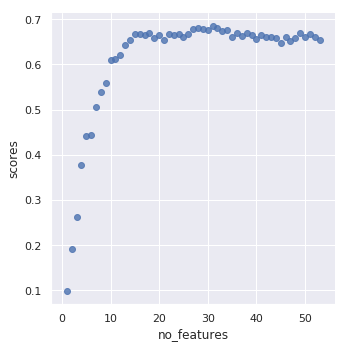

In [20]:
sns.set(rc={'figure.figsize':(15.7,15.27)})
sns.lmplot(data = RFCV_df, x = 'no_features', y = 'scores', fit_reg=False)

### Rankings of features based on multiple models

* random forest classifier feature importances
* RFE with RFC
* gradient boosting machine feature importances
* logistic regression coefficients



In [21]:
def getFeatImportances(model, X, y, featImportances = True):
    
    model.fit(X,y)
    return(model.feature_importances_)

        

In [22]:
my_scaler = MinMaxScaler()

In [27]:
RFC_ranks = my_scaler.fit_transform(getFeatImportances(RandomForestClassifier(random_state=random_seed_state), X, y).reshape(-1,1)).tolist()
RFC_ranks_scaled = []
for i in RFC_ranks:
    RFC_ranks_scaled.append(i[0])

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
GBM_ranks = my_scaler.fit_transform(getFeatImportances(GradientBoostingClassifier(), X, y).reshape(-1,1)).tolist()
GBM_ranks_scaled = []
for i in GBM_ranks:
    GBM_ranks_scaled.append(i[0])

In [29]:
RFE_ranks = my_scaler.fit_transform(my_rfc_selector.ranking_.reshape(-1, 1)).tolist()
RFE_ranks_scaled = []
for i in RFE_ranks:
    RFE_ranks_scaled.append(i[0])

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
RFC_ranks = getFeatImportances(RandomForestClassifier(random_state=random_seed_state),X,y)

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [31]:
GBM_ranks = getFeatImportances(GradientBoostingClassifier(random_state=random_seed_state),X,y)

In [32]:
RFE_ranks = my_rfc_selector.ranking_

In [33]:
rankings = pd.DataFrame(data = {'feature':X.columns.values, 'RFC':list(RFC_ranks_scaled), 'GBM':list(GBM_ranks_scaled), 'RFE':list(RFE_ranks_scaled)})

In [34]:
def meanRanks(row):
    return((row['RFC'] + row['GBM'] + row['RFE']) / 3)
rankings['mean_rank'] = rankings.apply(meanRanks, axis = 1)

In [35]:
rankings.sort_values(by = 'mean_rank', ascending=False, inplace=True)

In [36]:
rankings

,feature,RFC,GBM,RFE,mean_rank
13,Cr52,1.000000,1.000000,0.000000,0.666667
2,B11,0.774803,0.860269,0.000000,0.545024
7,S33,0.600331,0.992910,0.000000,0.531080
52,U238,0.662293,0.909545,0.000000,0.523946
9,Ca42,0.638422,0.799519,0.000000,0.479314
3,Mg24,0.601097,0.528210,0.000000,0.376436
47,Lu175,0.050810,0.017048,1.000000,0.355953
26,Zr90,0.435194,0.584418,0.000000,0.339870
45,Tm169,0.033072,0.009255,0.954545,0.332291
48,Hf178,0.042627,0.036719,0.909091,0.329479


In [37]:
y_array = np.array(y)

In [38]:
feats = []
scores = []
no_feats = []
features = list(rankings['feature'])
esti_rank = RandomForestClassifier(n_estimators=1000 , n_jobs=-1, random_state=random_seed_state)
for i in range(0, len(features)):
    i_2 = i + 1
    my_feats = features[0:i_2]
    feats.append(my_feats)
    no_feats.append(len(my_feats))
    print('building models with following features... {0}'.format(my_feats))
    
    X_array = np.array(X[my_feats])
    
    skf = StratifiedKFold(n_splits=3, random_state=random_seed_state)
    skf.get_n_splits(X_array, y_array)

    macro_f1_scores = []
    count = 0

    for train_index, test_index in skf.split(X_array, y_array):
        count = count + 1
        print('making model:')
        key = 'round' + str(count)
        print(count)
        X_train, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_array[train_index], y_array[test_index]

        esti_rank.fit(X_train, y_train)
        y_pred = esti_rank.predict(X_test)
        indi_score = f1_score(y_test, y_pred, average = 'weighted')
       
        macro_f1_scores.append(f1_score(y_test, y_pred, average = 'weighted'))
        
    
    
    scores.append(np.array(macro_f1_scores).mean())

building models with following features... ['Cr52']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33']
making model:
1
making model:
2


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42']
making model:
1
making model:
2
making model:
3


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24']
making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175']
making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90']
making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169']
making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178']
making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51']
making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165']
making model:
1
making 

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59']
making model:
1
making model:
2
making model:
3


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59', 'Cs133']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59', 'Cs133', 'Mn55']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137'

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59', 'Cs133', 'Mn55', 'Si28', 'Ga69', 'Pr141', 'La139', 'Nb93', 'Gd157']
making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59', 'Cs133', 'Mn55', 'Si28', 'Ga69', 'Pr141', 'La139', 'Nb93', 'Gd157', 'Sm147']
making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59', 'Cs133', 'Mn55', 'Si28', 'Ga69', 'Pr141', 'La139', 'Nb93', 'Gd157', 'Sm147', 'Cu63']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59', 'Cs133', 'Mn55', 'Si28', 'Ga69', 'Pr141', 'La139', 'Nb93', 'Gd157', 'Sm147', 'Cu63', 'Zn68']
making model:
1
making model:
2
making model:
3
building models with following

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59', 'Cs133', 'Mn55', 'Si28', 'Ga69', 'Pr141', 'La139', 'Nb93', 'Gd157', 'Sm147', 'Cu63', 'Zn68', 'Ni60', 'As75', 'Sn118', 'Nd146', 'Y89', 'Ti47']
making model:
1
making model:
2
making model:
3
building models with following features... ['Cr52', 'B11', 'S33', 'U238', 'Ca42', 'Mg24', 'Lu175', 'Zr90', 'Tm169', 'Hf178', 'V51', 'Rb85', 'Tb159', 'Ge72', 'Sc45', 'Ho165', 'P31', 'Ta181', 'In115', 'Sr88', 'Ba137', 'Er166', 'Eu153', 'Yb172', 'Fe56', 'Be9', 'Al27', 'Mo95', 'Th232', 'K39', 'Li7', 'Pb208', 'Ce140', 'Dy163', 'Co59', 'Cs133', 'Mn55', 'Si28', 'Ga69', 'Pr141', 'La139', 'Nb93', 'Gd157', 'Sm147', 'Cu63', 'Zn68', 'Ni60', 'As75', 'Sn11

In [39]:
rankedModels_df = pd.DataFrame(data = {'features': feats, 'number_of_features': no_feats, 'scores': scores})

In [40]:
rankedModels_df

,features,number_of_features,scores
0,[Cr52],1,0.125155
1,"[Cr52, B11]",2,0.223884
2,"[Cr52, B11, S33]",3,0.281821
3,"[Cr52, B11, S33, U238]",4,0.357163
4,"[Cr52, B11, S33, U238, Ca42]",5,0.405163
5,"[Cr52, B11, S33, U238, Ca42, Mg24]",6,0.479352
6,"[Cr52, B11, S33, U238, Ca42, Mg24, Lu175]",7,0.486427
7,"[Cr52, B11, S33, U238, Ca42, Mg24, Lu175, Zr90]",8,0.532418
8,"[Cr52, B11, S33, U238, Ca42, Mg24, Lu175, Zr90...",9,0.522330
9,"[Cr52, B11, S33, U238, Ca42, Mg24, Lu175, Zr90...",10,0.529966


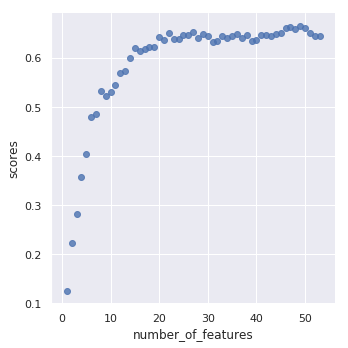

In [41]:
sns.lmplot(data = rankedModels_df, x = 'number_of_features', y = 'scores', fit_reg=False)

In [47]:
best_feats_row = rankedModels_df[rankedModels_df['number_of_features'] == 49]

In [48]:
best_feats_ranks = list(best_feats_row['features'])[0]

In [49]:
best_feats_ranks

['Cr52',
 'B11',
 'S33',
 'U238',
 'Ca42',
 'Mg24',
 'Lu175',
 'Zr90',
 'Tm169',
 'Hf178',
 'V51',
 'Rb85',
 'Tb159',
 'Ge72',
 'Sc45',
 'Ho165',
 'P31',
 'Ta181',
 'In115',
 'Sr88',
 'Ba137',
 'Er166',
 'Eu153',
 'Yb172',
 'Fe56',
 'Be9',
 'Al27',
 'Mo95',
 'Th232',
 'K39',
 'Li7',
 'Pb208',
 'Ce140',
 'Dy163',
 'Co59',
 'Cs133',
 'Mn55',
 'Si28',
 'Ga69',
 'Pr141',
 'La139',
 'Nb93',
 'Gd157',
 'Sm147',
 'Cu63',
 'Zn68',
 'Ni60',
 'As75',
 'Sn118']

In [50]:
%store best_feats_ranks
%store best_feats

Stored 'best_feats' (list)
Stored 'best_feats_rfe' (list)
